In [1]:
! pip install -qq seperability
from seperability import Model
import matplotlib.pyplot as plt
import torch

opt = Model("facebook/opt-125m", limit=1000)

- Loaded facebook/opt-125m
 - Registered 12 OPT Attention Layers


torch.Size([25, 14, 768])
torch.Size([25, 768]) tensor([ 1.6768,  1.7539,  1.8444,  1.9136,  1.9692,  2.0815,  2.1247,  2.2577,
         2.2602,  2.3382,  2.4701,  2.6676,  2.8537,  3.1282,  3.4777,  3.7126,
         4.1165,  4.5651,  5.2664,  6.0723,  6.7336,  8.3643,  9.0930,  9.6962,
        29.1578], device='cuda:0')
torch.Size([50272])
tensor(0.3500, device='cuda:0', grad_fn=<MaxBackward1>)


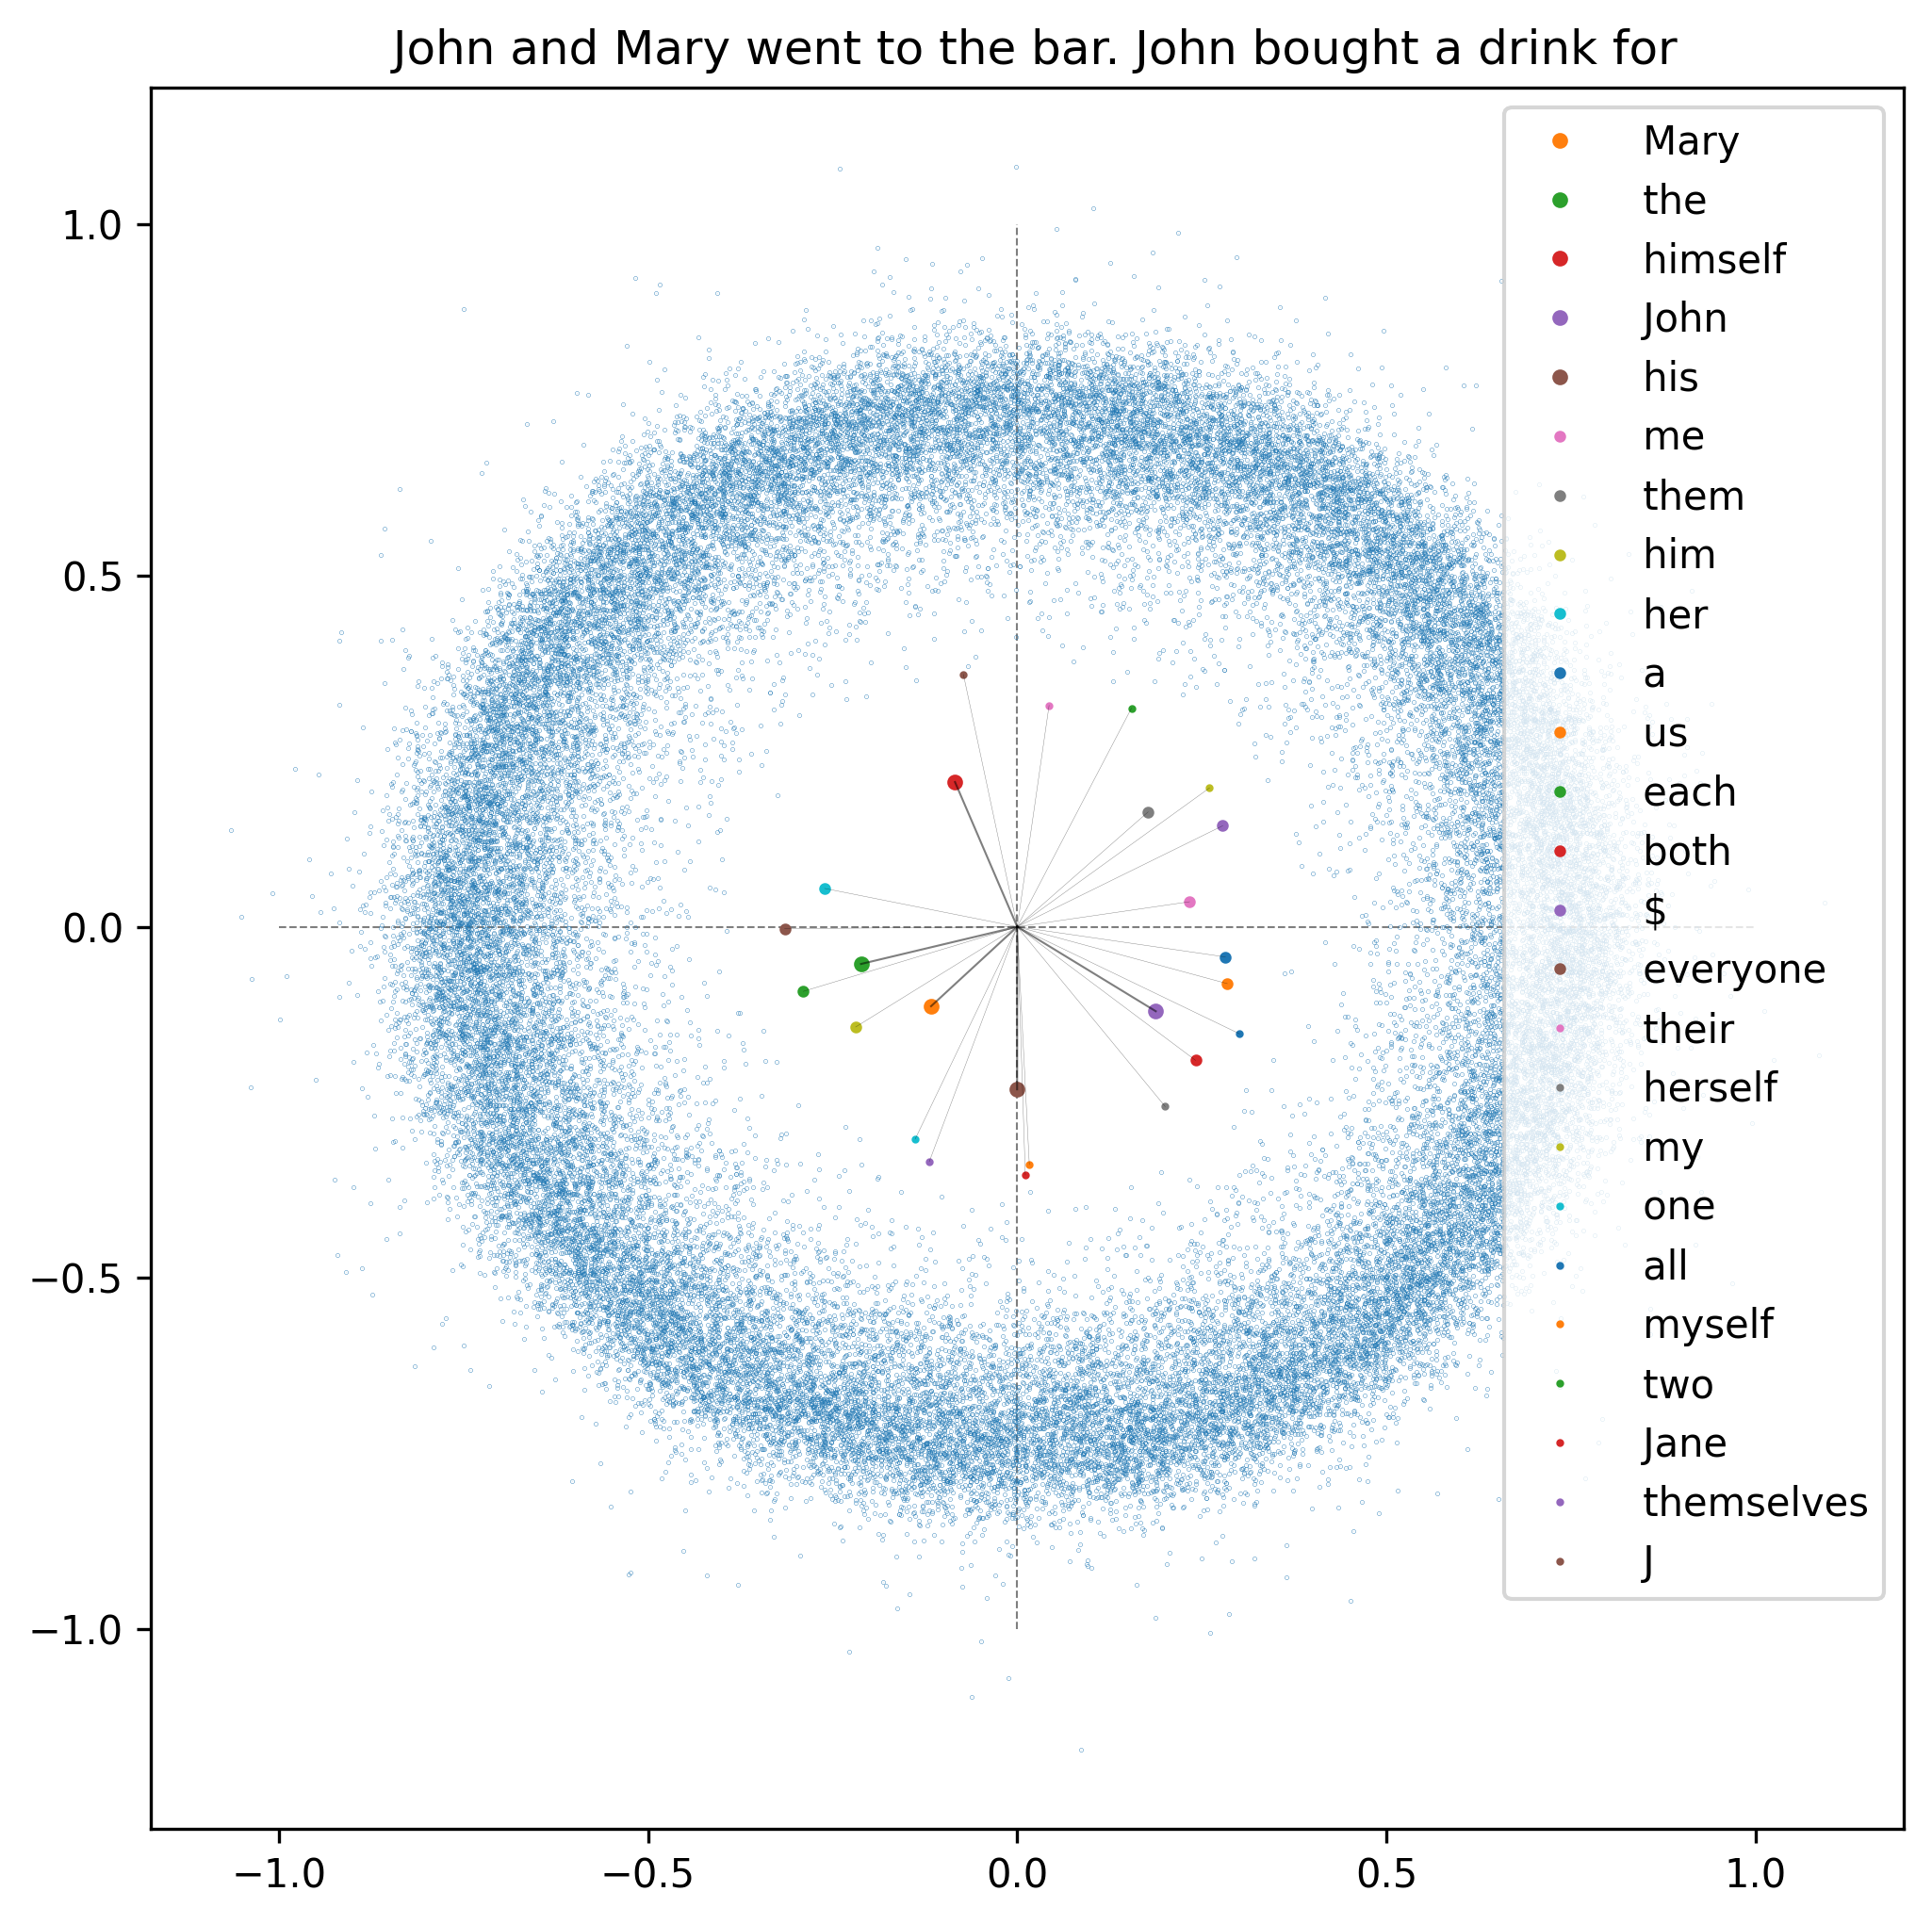

In [29]:
lm_head = opt.model.decoder.embed_tokens.weight
# lm_head = lm_head / lm_head.norm(dim=1).unsqueeze(1)

text = " John and Mary went to the bar. John bought a drink for"
text_residual = opt.get_residual_stream(text)
print(text_residual.shape)
token_residual = text_residual.transpose(0,1)[-1]
print(token_residual.shape, token_residual.norm(dim=-1))
out_vec = token_residual[-1]
out_vec = out_vec / out_vec.norm()

logits = opt.unembed(out_vec.detach())
logits = torch.matmul(lm_head, out_vec)
print(logits.shape)
print(logits.max())

logit_max = ( 0.5*out_vec.norm() + 1.5*logits.max()) / 2
distance = (logits - logit_max).abs()

with torch.no_grad():
    rand_vectors = torch.randn( len(distance), 2 ).detach()
    rand_vectors = rand_vectors / rand_vectors.norm(dim=1).unsqueeze(1)
    rand_vectors = rand_vectors * distance.unsqueeze(1).cpu()

# Create figure
plt.figure(figsize=(8,8))
plt.hlines(0, -1, 1, linestyles='dashed', colors='black', alpha=0.5, linewidth=0.5)
plt.vlines(0, -1, 1, linestyles='dashed', colors='black', alpha=0.5, linewidth=0.5)

xs, ys = rand_vectors[:, 0], rand_vectors[:, 1]
plt.plot( xs, ys, "o", markersize=0.1 )

top_indices = torch.topk(-distance, 25).indices
for i in top_indices[:5]:
    i_str = opt.tokenizer.decode(i)
    plt.plot( xs[i], ys[i], "o", markersize=3, label=i_str )
    plt.plot( [0, xs[i]], [0, ys[i]], "k-", linewidth=0.5, alpha=0.5)
    
for i in top_indices[5:15]:
    i_str = opt.tokenizer.decode(i)
    plt.plot( xs[i], ys[i], "o", markersize=2, label=i_str )
    plt.plot( [0, xs[i]], [0, ys[i]], "k-", linewidth=0.1, alpha=0.5)

for i in top_indices[15:]:
    i_str = opt.tokenizer.decode(i)
    plt.plot( xs[i], ys[i], "o", markersize=1, label=i_str )
    plt.plot( [0, xs[i]], [0, ys[i]], "k-", linewidth=0.1, alpha=0.5)

plt.legend(loc="upper right") 
plt.title(text)
plt.show()